# $$FaceNet$$

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
from PIL import Image
import keras
# import pydot
# import pydotplus
# from pydotplus import graphviz
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import clear_output
# keras.utils.vis_utils.pydot = pydot

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
# %load_ext autoreload
# %autoreload 2

## Использование FaceNet для кодирования изображений

Модель FaceNet предполагает использование огромного числа данных (изображений лица), и как следствие, требует много времени на обучение из-за сложности модели. Поэтому в нашем примере, мы будем использовать упрощенную версию FaceNet и использовать зараннее обученные веса. Веса и структура модели были взяты отсюда 

- В нашей модели на вход подаются RGB изображения размером 96 на 96 пикселей.
- На выходе мы получаем вектор размерности (128, ) - закодированное изображение.

In [2]:
K.set_image_data_format("channels_last")

In [3]:
FRmodel = faceRecoModel(input_shape=(96, 96, 3))

In [4]:
print("Total trainable parameters: ", FRmodel.count_params())

Total trainable parameters:  3743280


## Система распознавания человека на изображении

Для того, чтобы модель FaceNet могла успешно справляться с задачей распознавания человека на изображении, ей необходимо обращаться к базе данных изображений лица каждого человека. Модель последовательно будет сравнивать входящее изоражение со всеми остальными из базы, и находить наиболее "приближенное" к нему.

В следующей строке кода загружается база данных изображений лиц нашей команды

In [5]:
database = load_database(FRmodel)

<img src="images/markdown/model_work.jpg">

### Алгоритм распознавания определенного человека на изображении будет строится следующим образом:

- Преобразуем полученное изображение в вектор размерности (96, 96, 3)
- Пропустим этот вектор через модель FaceNet
- Получим в качестве результата вектор размерности (128, )
- Сравним расстояния между изображениями каждого человека в базе (изображений каждого человека может быть несколько) и выберем минимальное
- Если получено расстояние ($r$) $< \alpha$, то на изображении находиться человек из базы данных
- Иначе человека на изображении не удалось опознать.

### Структура FaceNet

Под капотом модели FaceNet фигурируют 4 основных вида нейронов:

- Сверточный нейрон (Conv2D) - выделение признаков

- Субдискретизация (Max pooling) - сжатие признаков

- Нормализация (Batch Normalization) - нормализация признаков по каждой партии

- Нейрон активации (используется RELU)

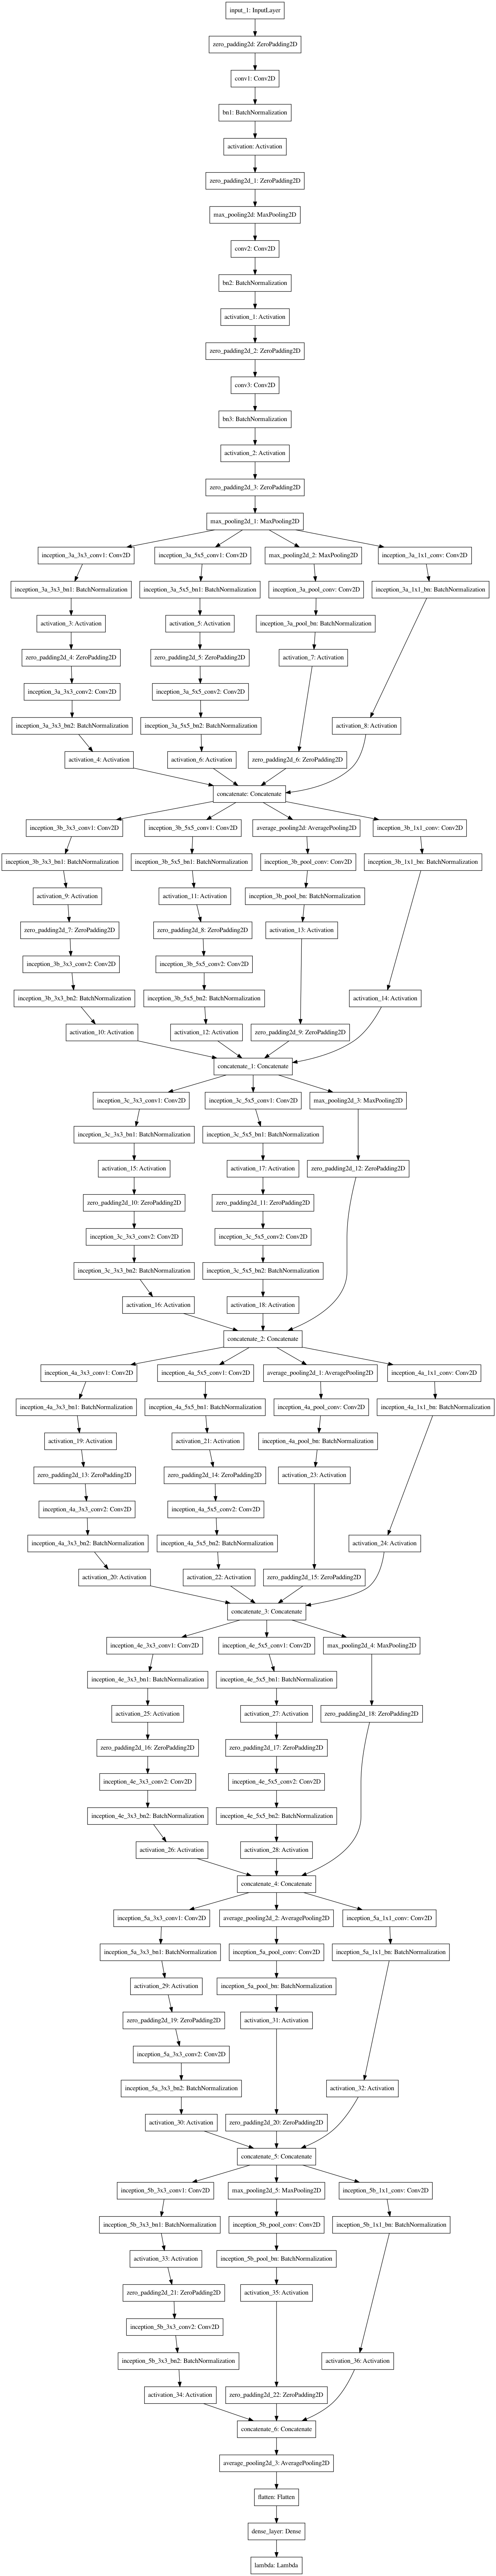

In [6]:
tf.keras.utils.plot_model(
    FRmodel, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Функция триангуляции (triangle loss)

Вишенкой на торте у FaceNet является ее необычная функция потерь. Ниже приведена логика ее работы:

Пусть $f$ \- это наша модель FaceNet, а $x$ \- это очередное входящее изображение

Тогда $f(x)$ будет равно:
    
<img src="images/markdown/f(x).jpg">

### Введем понятия якоря, положительного и негативного изображения

- Якорь (anchor) - очередное поступающее изображение. Обозначем за $A$ и функция модели будет равна $f(A)$
- Положит. изобр. (positive) - изображение того же человека, что и на якоре. Обозначем за $P$ и функция модели будет равна $f(P)$
- Негативное изобр. (anchor) - изображение другого человека, не совпадающее с якорем. Обозначем за $N$ и функция модели будет равна $f(N)$

$X_i$ будем обозначать $i$-ое изображение (anchor, positive или negative)

Функция триангуляции работает таким образом, чтобы у положительного изображения было расстояние гораздо меньше, чем у негативного, как минимум на коэффициент $\alpha$:

<img src="images/markdown/andrey_dima.jpg">

$$\mid \mid f(A_{i}) - f(P_{i}) \mid \mid^2 + \alpha < \mid \mid f(A_{i}) - f(N_{i}) \mid \mid^2$$


Поэтому, мы будем минимизировать следующую функцию:

$$\mathcal{J} = \sum^{m}_{i=1} \large max( \small \mid \mid f(A_{i}) - f(P_{i}) \mid \mid^2 - \mid \mid f(A_{i}) - f(N_{i}) \mid \mid^2+ \alpha \large, 0 ) \small$$

In [7]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)

    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)

    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

## Компиляция модели

В качестве оптимизатора возьмем Adam

Функцию потерь будем использовать triplet loss

Метрика - точность модели

Так как, на полное обучение модели требуется примерно 20 млн. изображений лиц, то мы пропустим эту часть, и сразу же загрузим уже натренированные веса

In [8]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)
database = load_database(FRmodel)

## Пример работы программы

Следующая функция отгадывает человека из базы данных (database) на изображении (image_path) при помощи модели (model)

In [9]:
def who_is_it(image_path, database, model):

    encoding = img_to_encoding(image_path, model) # преобразуем картинку в вектор (128, )
    min_dist = 100 # ставим минимальное расстояние максимально возможным
    alpha = 0.7 # наш коэффициент
    
    for (name, db_enc) in database.items():
        for image in db_enc:
            dist = np.linalg.norm(encoding - image)
            if dist < min_dist:
                min_dist = dist
                identity = name
    
    if min_dist > alpha:
        print("Not in the database.", min_dist)
    else:
        print ("It's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

It's Artem, the distance is 0.5188342
It's Dima, the distance is 0.5342773
It's Andrey, the distance is 0.4368203


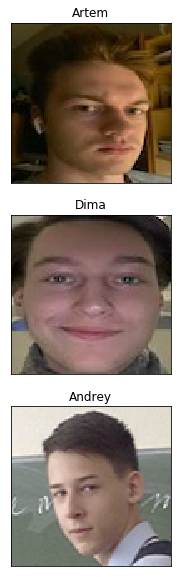

In [10]:
fig, axs = plt.subplots(3, figsize=(10, 10))
path = os.getcwd() + '/images/test'
i = 0
for image in os.listdir(path):
    if image.endswith('.jpg'):
        min_dist, identity = who_is_it(os.path.join(path, image), database, FRmodel)
        axs[i].imshow(np.array(Image.open(os.path.join(path, image)).getdata()).reshape(96, 96, 3))
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(identity)
        i += 1

In [11]:
ready_to_detect_identity = True
PADDING = 20           
def webcam_face_recognizer(database):
    global ready_to_detect_identity

    cv2.namedWindow("preview")
    vc = cv2.VideoCapture(0)

    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    while vc.isOpened():
        _, frame = vc.read()
        img = frame

        if ready_to_detect_identity:
            img = process_frame(img, frame, face_cascade)   
        
        key = cv2.waitKey(100)
        cv2.imshow("preview", img)

        if key == 27: # exit on ESC
            break
    cv2.destroyWindow("preview")

def process_frame(img, frame, face_cascade):
    global ready_to_detect_identity, database
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    identity = None
    for (x, y, w, h) in faces:
        x1 = x-PADDING
        y1 = y-PADDING
        x2 = x+w+PADDING
        y2 = y+h+PADDING

        img = cv2.rectangle(frame,(x1, y1),(x2, y2),(255,0,0),2)

        identity = find_identity(frame, x1, y1, x2, y2)
        
        clear_output(wait=True)
        if identity in database:
            print(identity)

    return img

def find_identity(frame, x1, y1, x2, y2):
    height, width, channels = frame.shape
    part_image = frame[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]
    
    return who_is_it_webcam(part_image, database, FRmodel)

def who_is_it_webcam(image, database, model):
    encoding = img_to_encoding_webcam(image, model)
    
    min_dist = 100
    identity = None
    
    for (name, db_enc) in database.items():
        for image in db_enc:
            dist = np.linalg.norm(encoding - image)
            if dist < min_dist:
                min_dist = dist
                identity = name
    
    if min_dist > 0.7:
        return None
    else:
        return str(identity)

In [ ]:
webcam_face_recognizer(database)

Artem
